# Error propagration with taking into account of correlations b/w parameters

In other notebook, we showed that, for higher redshifts, errorbars in SFRD are pretty large; could this be due to correlation among parameters -- meaning the Schechter function parameters, $M_*$, $\phi_*$ and $\alpha$ are not independent of each other. Previously we considered them as independent Gaussian variables. Now, we would like to take in account of this correlations. We, however, first treat them as Gaussian independent variables and see what we could get, i.e., we check how well we can constrain SFRD.

In the following notebook, we use data from [Bouwens+15](https://ui.adsabs.harvard.edu/abs/2015ApJ...803...34B/abstract).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as con
import os
import corner
import utils as utl
import posdef as pdf
from tqdm import tqdm
import scipy.integrate as inte

In [2]:
# Redshift
z_bou = np.array([4,5,6,7,8])

# Characteristic absolute magnitude
mst_bou = np.array([-20.88, -21.17, -20.94, -20.87, -20.63])
msterr_bou = np.array([0.08, 0.12, 0.2, 0.26, 0.36])

# Characteristic luminosity
lst_bou = np.array([])
lsterr_bou = np.array([])

for i in range(len(mst_bou)):
    mst1 = np.random.normal(mst_bou[i], msterr_bou[i], 10000)
    lst1 = utl.m_to_l_wave(mst1, 1500)
    lst_bou = np.hstack((lst_bou, np.mean(lst1)))
    lsterr_bou = np.hstack((lsterr_bou, np.std(lst1)))

# Alpha
alp_bou = np.array([-1.64, -1.76, -1.87, -2.06, -2.02])
alperr_bou = np.array([0.04, 0.05, 0.1, 0.13, 0.23])

# Normalisation constant
phi_bou = np.array([1.97, 0.74, 0.50, 0.29, 0.21])*0.001
phierr_bou = np.array([0.3, 0.16, 0.19, 0.16, 0.17])*0.001

log_phi_bou, log_phi_bou_err = utl.log_err(phi_bou, phierr_bou)


# Kappas
sol_lum = (con.L_sun*1e7).value
kap_uv = 2.2e-10/sol_lum
kap_ir = 4.5*10**(-44)

# Range of Luminosities (or absolute magnitudes) used
mags_bou = np.linspace(-24, -13, 1000)
lums_bou = utl.m_to_l_wave(mags_bou, 1500)

#print(np.log10(lst_bou))
#print(np.log10(lsterr_bou))
#print(np.log10(lums_bou))

In [3]:
sfrd_bou = np.array([])
sfrd_err_bou = np.array([])

z_bou1 = np.array([z_bou[2]])

for i in range(len(z_bou)):
    sfr1, sfr_e1 = utl.sfrd_w_err(lum=lums_bou, lum1=lst_bou[i], lum1err=lsterr_bou[i], phi1=phi_bou[i], phi1err=phierr_bou[i], alpha=alp_bou[i], alphaerr=alperr_bou[i], kappa=kap_uv)
    #print('\n SFRD')
    #print(sfr1)
    #print(sfr_e1)
    if sfr1 != 0:
        sfrd_bou = np.hstack((sfrd_bou, sfr1))
        sfrd_err_bou = np.hstack((sfrd_err_bou, sfr_e1))

  0%|          | 10/10000 [00:00<01:43, 96.50it/s]
length: 
10000
  0%|          | 10/10000 [00:00<01:46, 94.24it/s]
length: 
10000
  0%|          | 9/10000 [00:00<01:54, 86.89it/s]
length: 
10000
  0%|          | 9/10000 [00:00<01:55, 86.47it/s]
length: 
10000
100%|██████████| 10000/10000 [01:48<00:00, 92.44it/s]
length: 
9986



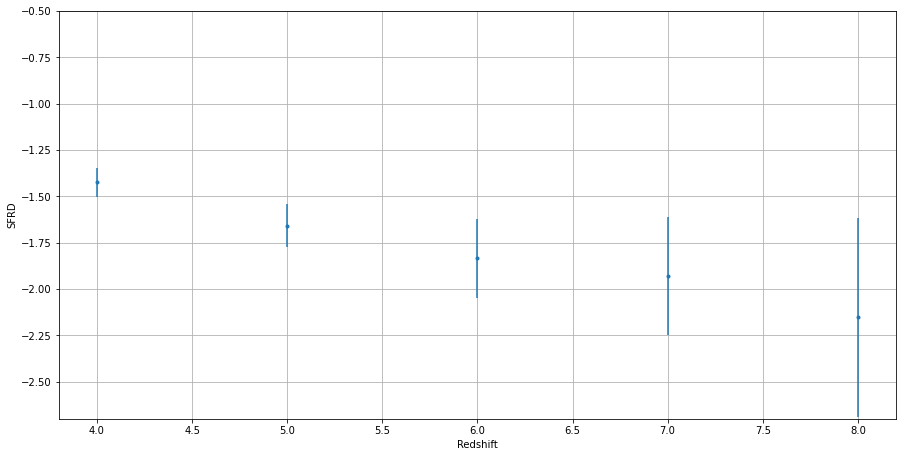

In [4]:
log_sfrd_bou = np.array([])
log_sfrd_bou_err = np.array([])

for i in range(len(sfrd_bou)):
    par, err = utl.log_err(sfrd_bou[i], sfrd_err_bou[i])
    log_sfrd_bou = np.hstack((log_sfrd_bou, par))
    log_sfrd_bou_err = np.hstack((log_sfrd_bou_err, err))

plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou, yerr=log_sfrd_bou_err, fmt='.')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.ylim([-2.7, -0.5])
plt.grid()

As with the other notebook, errorbars are pretty large, epsecially for the higher redshifts.

## Generating correlated parameters

We now want to take into account of correlations between parameters. To do so, we use the covariance matrix (calculated elsewhere) for each redshift and draw random normal sample using this matrix, using `numpy.random.multivariate_normal` function. However, before using it into the practice, we first want to check if it works properly or not.

Hence, below we draw a sample using the following covariance matrix,

\begin{bmatrix}
0.03753042 & 0.0276935 & 0.01513143\\
0.0276935 & 0.02369625 & 0.01337057\\
0.01513143 & 0.01337057 & 0.00942249
\end{bmatrix}

to draw samples of $M_*$, $\log{\phi_*}$ and $\alpha$ (the order of this, by the way represents the order in the given covariance matrix). we use the given mean values of the parameters, and above covariance matrix and `numpy.random.multivariate_normal` function to generate 10000 samples of $M_*$, $\log{\phi_*}$ and $\alpha$. We also plot them to see if it works properly or not.

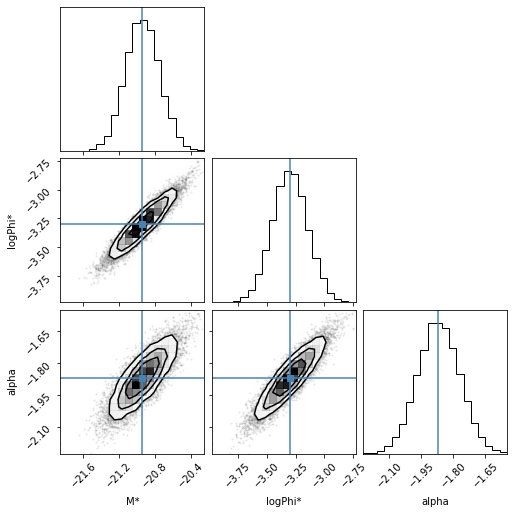

In [5]:
means_mpa = np.array([-20.94, -3.3010299956639813, -1.87])

cov_mpa = np.array([[0.03753042, 0.0276935, 0.01513143],\
                   [0.0276935, 0.02369625, 0.01337057],\
                    [0.01513143, 0.01337057, 0.00942249]])

samples = np.random.multivariate_normal(means_mpa, cov_mpa, 10000)

lbs = np.array(['M*', 'logPhi*', 'alpha'])

corner.corner(samples, labels=lbs, truths=means_mpa)
plt.show()

We now convert $M_*$ and $\log{\phi_*}$ into $L_*$ and $\phi_*$, respectively. This would give us the correlated samples of $L_*$, $\phi_*$ and $\alpha$.

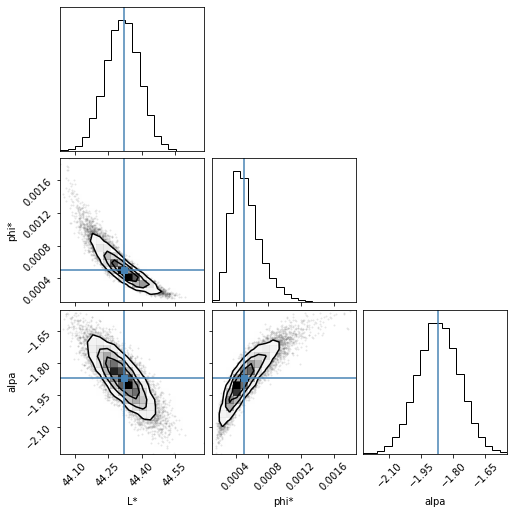

In [6]:
lum_6 = np.log10(utl.m_to_l_wave(samples.T[0], 1500))
phi_6 = 10**samples.T[1]
alp_6 = samples.T[2]

ab = np.vstack((lum_6, phi_6))
new_samples = np.vstack((ab, alp_6)).T

corner.corner(new_samples, truths=np.array([np.log10(lst_bou[2]), phi_bou[2], alp_bou[2]]), labels=np.array(['L*', 'phi*', 'alpa']))
plt.show()

Well, it seems to work properly. We can now write a short function that takes the mean values and the covariance matrix and returns the correlated samples for $L_*$, $\phi_*$ and $\alpha$.

In [7]:
def corr_para(means, covs):
    """
    To generate correlated samples
    ------------------------------
    Parameters
    ----------
    means : numpy.ndarray
        means of the parameters (M*, logphi, alpha)
    covs : numpy.ndarray of shape (len(means), len(means))
        covariance matrix of the parameters
    ----------
    returns
    ----------
    numpy.ndarray:
        correlated samples of L*
    numpy.ndarray:
        correlated samples of phi*
    numpy.ndarray:
        correlated samples of alpha
    """
    samples1 = np.random.multivariate_normal(means, covs, 10000)
    lum_z = utl.m_to_l_wave(samples1.T[0], 1500)
    phi_z = 10**samples1.T[1]
    alp_z = samples1.T[2]
    return lum_z, phi_z, alp_z

Before performing the entire calculations for the whole range of redshifts, we do the computation for just this redshift first. Even before that, let's check if the function we wrote to return correlated samples works or not.

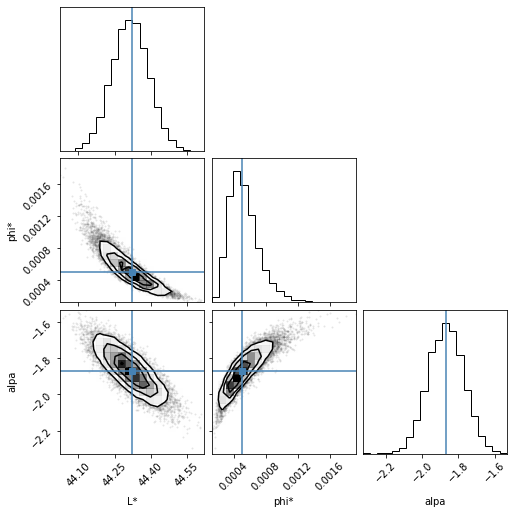

In [8]:
lst621, phi62, alp62 = corr_para(means=means_mpa, covs=cov_mpa)
lst62 = np.log10(lst621)
samp1 = np.vstack((lst62, phi62))
samp2 = np.vstack((samp1, alp62))
corner.corner(samp2.T, truths=np.array([np.log10(lst_bou[2]), phi_bou[2], alp_bou[2]]), labels=np.array(['L*', 'phi*', 'alpa']))
plt.show()

It's working!! So now let's compute SFRD for this redshift...

In [9]:
nor_lum1 = np.linspace(0.03*lst_bou[2], np.max(lums_bou), 10000)
print('Range of L (in log): ')
print(np.log10(nor_lum1))
rho_6 = np.array([])
# Integration starts
for i in tqdm(range(10000)):
    if lum_6[i] < 0 :#alp2[i] != alp2[i] or lum2[i] != lum2[i] or lum2[i] == 0 or phi2[i] != phi2[i]:
        continue
    else:
        nor_sc6 = utl.schechter(nor_lum1, lum1=lst621[i], phi1=phi62[i], alpha=alp62[i])
        nor_sc_6 = nor_lum1*nor_sc6#/phi2[j]
        rho_nor1 = inte.simps(nor_sc_6, nor_lum1)
        rho_6 = np.hstack((rho_6, rho_nor1))
print('Mean and std of rho: {:.2e} and {:.2e}'.format(np.mean(rho_6), np.std(rho_6)))
sfrd62 = rho_6*kap_uv
log_sfrd62, log_sfrd62_err = utl.log_err(np.mean(sfrd62), np.std(sfrd62))
print('Mean and std of SFRD (in log): {:.2e} and {:.2e}'.format(log_sfrd62, log_sfrd62_err))

  1%|          | 68/10000 [00:00<00:14, 674.15it/s]Range of L (in log): 
[42.79739439 42.82065437 42.84273167 ... 45.53855999 45.53860335
 45.53864671]
100%|██████████| 10000/10000 [00:12<00:00, 800.24it/s]Mean and std of rho: 2.48e+41 and 2.57e+40
Mean and std of SFRD (in log): -1.85e+00 and 4.50e-02



Sounds good to me! Now let's repeat the whole procedure for rest of the redshifts.

In [10]:
mean_4 = np.array([-20.88, -2.705533773838407, -1.64])
mean_5 = np.array([-21.17, -3.1307682802690238, -1.76])
mean_6 = np.array([-20.94, -3.3010299956639813, -1.87])
mean_7 = np.array([-20.87, -3.537602002101044, -2.06])
mean_8 = np.array([-20.63, -3.677780705266081, -2.02])

means_bou = [mean_4, mean_5, mean_6, mean_7, mean_8]

cov_4 = np.array([[0.00686333, 0.00441759, 0.00248485],\
    [0.00441759, 0.00497807, 0.00171691],\
    [0.00248485, 0.00171691, 0.00160949]])
cov_51 = np.array([[0.0149319, 0.00998742, 0.01298852],\
    [0.00998742, 0.00888349, 0.0031456],\
    [0.01298852, 0.0031456, 0.00715884]])
cov_5 = pdf.nearestPD(cov_51)
cov_6 = np.array([[0.03753042, 0.0276935, 0.01513143],\
    [0.0276935, 0.02369625, 0.01337057],\
    [0.01513143, 0.01337057, 0.00942249]])
cov_7 = np.array([[0.06717874, 0.05548699, 0.02702375],\
    [0.05548699, 0.05034289, 0.02577599],\
    [0.02702375, 0.02577599, 0.01724576]])
cov_8 = np.array([[0.11949126, 0.10168055, 0.06483851],\
    [0.10168055, 0.09233034, 0.06565599],\
    [0.06483851, 0.06565599, 0.05440462]])

covs_bou = [cov_4, cov_5, cov_6, cov_7, cov_8]

NameError: name 'np' is not defined

In [11]:
def lum_den22(lum, mean1, cov1, limit=0.03):
    """
    Function to calculate luminosity density
    ----------------------------------------
    Parameters:
    -----------
    lum : float, numpy.ndarray
        luminosity range
    mean1 : numpy.ndarray
        means of the parameters M*, logPhi* and alpha
    cov1 : numpy.ndarray
        covariance matrix of the parameters
        size must be (3x3)
    limit : float
        lower limit of the intensity
        as a function of L*
        default is 0.03 (from Madau&Dickinson)s
    -----------
    return
    -----------
    numpy.ndarray
        an array of luminosity density
    """
    # Values of Parameters
    lum2, phi2, alp2 = corr_para(means=mean1, covs=cov1)
    lum1 = utl.m_to_l_wave(mean1[0], 1500)
    # Values of luminosities
    nor_lum = np.linspace(limit*lum1, np.max(lum), 100000)
    # Integration array
    rho2 = np.array([])
    # Integration starts
    for i in tqdm(range(10000)):
        if lum2[i] < 0 :#alp2[i] != alp2[i] or lum2[i] != lum2[i] or lum2[i] == 0 or phi2[i] != phi2[i]:
            continue
        else:
            nor_sc1 = utl.schechter(nor_lum, lum1=lum2[i], phi1=phi2[i], alpha=alp2[i])
            nor_sc = nor_lum*nor_sc1#/phi2[j]
            rho_nor = inte.simps(nor_sc, nor_lum)
            rho2 = np.hstack((rho2, rho_nor))
    print("\nlength: ")
    print(len(rho2))
    return rho2


def sfrd_w_err(lum, mean2, cov2, kappa, limit=0.03):
    """
    Function to calculate luminosity density
    ----------------------------------------
    Parameters:
    -----------
    lum : float, numpy.ndarray
        luminosity range
    mean1 : numpy.ndarray
        means of the parameters M*, logPhi* and alpha
    cov1 : numpy.ndarray
        covariance matrix of the parameters
        size must be (3x3)
    kappa : float
        conversion factor b/w luminosity density and
        star formation rate
    limit : float
        lower limit of the intensity
        as a function of L*
        default is 0.03 (from Madau&Dickinson)
    -----------
    return
    -----------
    float
        mean star formation rate
    float
        error in star formation rate
    """
    lum_den2 = lum_den22(lum, mean2, cov2, limit)
    kpp1 = kappa
    sfr2 = kpp1*lum_den2
    return np.mean(sfr2), np.std(sfr2)

In [12]:
sfrd_bou_corr = np.array([])
sfrd_err_bou_corr = np.array([])

z_bou1 = np.array([z_bou[2]])

for i in range(len(z_bou)):
    sfr1, sfr_e1 = sfrd_w_err(lum=lums_bou, mean2=means_bou[i], cov2=covs_bou[i], kappa=kap_uv, limit=0.03)
    #print('\n SFRD')
    #print(sfr1)
    #print(sfr_e1)
    if sfr1 != 0:
        sfrd_bou_corr = np.hstack((sfrd_bou_corr, sfr1))
        sfrd_err_bou_corr = np.hstack((sfrd_err_bou_corr, sfr_e1))

100%|██████████| 10000/10000 [02:07<00:00, 78.21it/s]
ipykernel_launcher:21: RuntimeWarning: covariance is not positive-semidefinite.
  0%|          | 8/10000 [00:00<02:13, 75.01it/s]
length: 
10000
  0%|          | 8/10000 [00:00<02:17, 72.59it/s]
length: 
10000
  0%|          | 7/10000 [00:00<02:35, 64.11it/s]
length: 
10000
  0%|          | 7/10000 [00:00<02:30, 66.28it/s]
length: 
10000
100%|██████████| 10000/10000 [02:12<00:00, 75.53it/s]
length: 
10000



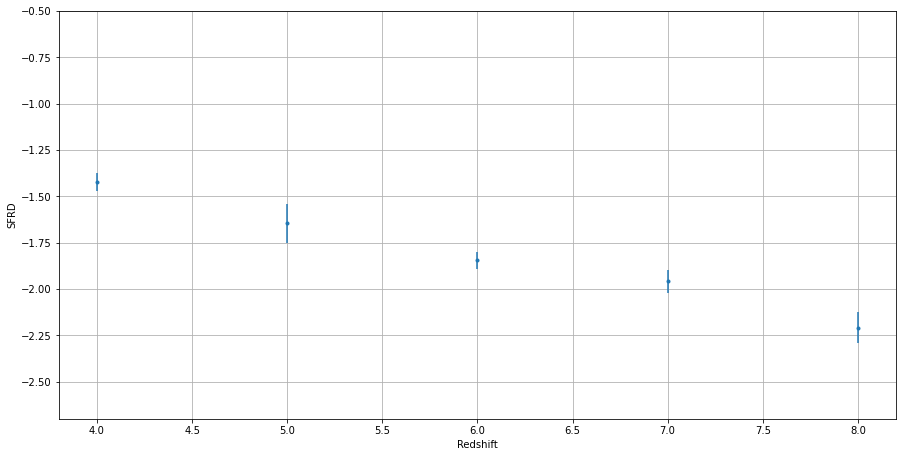

In [13]:
log_sfrd_bou_corr = np.array([])
log_sfrd_bou_err_corr = np.array([])

for i in range(len(sfrd_bou_corr)):
    par, err = utl.log_err(sfrd_bou_corr[i], sfrd_err_bou_corr[i])
    log_sfrd_bou_corr = np.hstack((log_sfrd_bou_corr, par))
    log_sfrd_bou_err_corr = np.hstack((log_sfrd_bou_err_corr, err))

plt.figure(figsize=(15,7.5))
plt.errorbar(z_bou, log_sfrd_bou_corr, yerr=log_sfrd_bou_err_corr, fmt='.')
plt.xlabel('Redshift')
plt.ylabel('SFRD')
plt.ylim([-2.7, -0.5])
plt.grid()